# Text Extraction and Recognition from Images

We are going to exploit a **Transformers based architecture**, in particular **TrOCR**.

In [27]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from transformers import TrOCRProcessor, VisionEncoderDecoderModel

plt.style.use('ggplot')

```annot.parquet``` and ```imgs.parquet``` contain annotations and image information respectively.

- ```annot.parquet```: It contains image annotations, such as **bounding boxes and transcriptions of the text inside the images**.
- ```imgs.parquet```: Contains **information about images, such as image IDs, resolution, file names**, or other information useful for loading images correctly.

.parquet files are used here as a storage format for a structured dataset (annotations and images), and the code loads this data for further processing.

In [28]:
annot = pd.read_parquet('/home/pierluigi/Documents/datasets/Text Extraction/annot.parquet')
imgs = pd.read_parquet('/home/pierluigi/Documents/datasets/Text Extraction/img.parquet')
img_fns = glob('/home/pierluigi/Documents/datasets/Text Extraction/train_images/*')

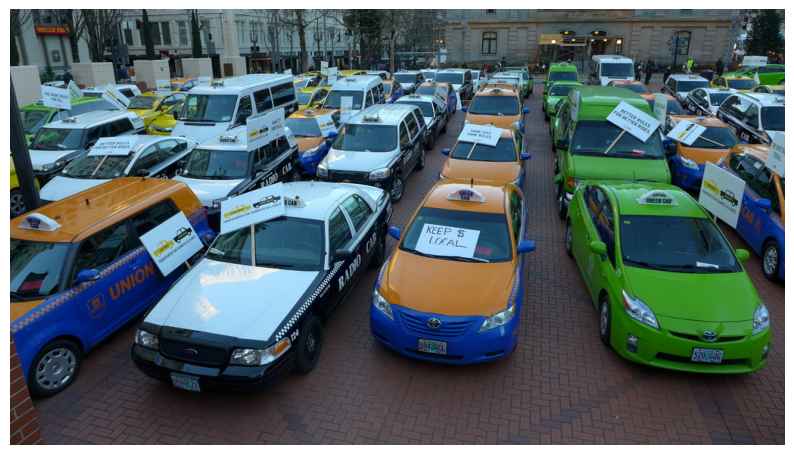

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[0]))
ax.axis('off')
plt.show()

Each image, through the annotation you have viewed, returns:

- **id**: **a unique identifier** for each annotation.
- **image_id**: **the image ID**, which in our example is "79911caf0396438c". This ID links the annotation to the corresponding image.
- **bbox**: **the coordinates of the bounding box for the area where the text is located in the image**. They are **in the format [x_min, y_min, width, height]**, which **defines the position and size of the bounding box where the text is located**.
- **utf8_string**: **the text transcribed inside the bounding box**. This is the text we want to extract from the images.
- **points**: **a list of points that represent the vertices of the bounding box**. These points are useful for a more precise delimitation.
- **area**: **the area covered by the bounding box, calculated as the product of the width and height of the box (in pixels)**.

Each row of the dataframe corresponds to a text annotation found in the image. For example, for the image with image_id = "79911caf0396438c", there are multiple annotations, each related to a different part of the image that contains text.

In [30]:
image_id = img_fns[0].split('/')[-1].split('.')[0] # Extracts the image ID from the filename in the img_fns list
annot.query('image_id == @image_id') # filter the annot dataframe, looking for annotations for the specified image via the extracted image_id

,id,image_id,bbox,utf8_string,points,area
277226,79911caf0396438c_1,79911caf0396438c,"[368.37, 419.01, 15.63, 21.57]",124,"[368.37, 431.28, 380.51, 419.01, 384.0, 431.93...",337.14
277227,79911caf0396438c_2,79911caf0396438c,"[215.05, 486.83, 15.23, 12.14]",959,"[215.69, 486.83, 230.28, 489.54, 229.64, 498.9...",184.89
277228,79911caf0396438c_3,79911caf0396438c,"[232.87, 490.32, 16.66, 12.78]",C22,"[233.38, 490.32, 249.4, 493.03, 249.53, 503.1,...",212.91
277229,79911caf0396438c_4,79911caf0396438c,"[127.94, 329.32, 66.78, 57.78]",UNION,"[127.94, 368.89, 187.97, 329.32, 194.72, 352.2...",3858.55
277230,79911caf0396438c_5,79911caf0396438c,"[194.04, 314.26, 29.9, 23.16]",.,"[194.04, 331.57, 219.45, 314.26, 223.94, 319.8...",692.48
277231,79911caf0396438c_6,79911caf0396438c,"[219.09, 305.31, 16.3, 13.8]",.,"[219.09, 315.01, 231.39, 305.31, 235.39, 310.2...",224.94
277232,79911caf0396438c_7,79911caf0396438c,"[231.69, 296.61, 15.5, 13.8]",.,"[231.69, 304.91, 243.99, 296.61, 247.19, 301.6...",213.90
277233,79911caf0396438c_8,79911caf0396438c,"[106.45, 378.7, 14.91, 17.42]",8,"[106.45, 384.64, 117.54, 378.7, 121.36, 391.11...",259.73
277234,79911caf0396438c_9,79911caf0396438c,"[25.4, 281.36, 13.8, 9.54]",US,"[25.55, 281.36, 39.2, 282.26, 38.29, 290.9, 25...",131.65
277235,79911caf0396438c_10,79911caf0396438c,"[280.47, 267.15, 36.98, 17.28]",.,"[280.47, 278.82, 316.24, 267.15, 317.45, 272.3...",639.01


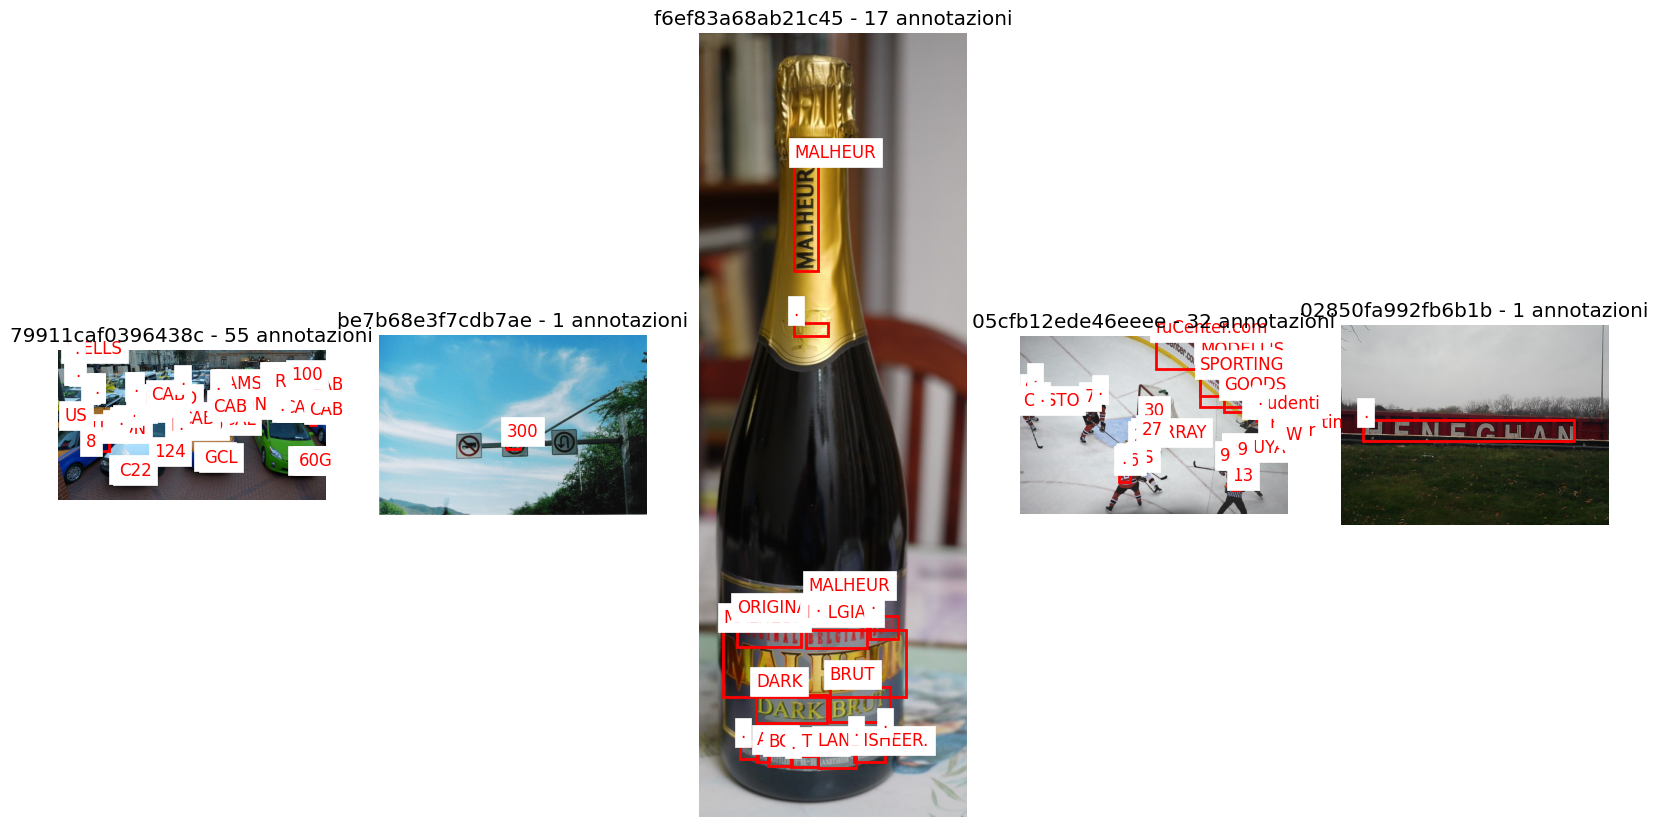

In [31]:
fig, axs = plt.subplots(1, 5, figsize=(20, 20))  # Griglia di 1x5
axs = axs.flatten()

for i in range(5):
    img = plt.imread(img_fns[i])
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    
    # Filtra le annotazioni per l'immagine corrente
    img_annot = annot.query('image_id == @image_id')
    
    # Mostra l'immagine
    axs[i].imshow(img)
    
    # Disegna i bounding box e il testo trascritto
    for _, row in img_annot.iterrows():
        # Estrai il bounding box e il testo
        bbox = row['bbox']
        text = row['utf8_string']
        
        # Aggiungi un rettangolo per il bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        axs[i].add_patch(rect)
        
        # Posiziona il testo sopra il bounding box
        axs[i].text(
            bbox[0], bbox[1] - 10, text, 
            color='red', fontsize=12, backgroundcolor='white'
        )
    
    axs[i].axis('off')  # Nasconde gli assi
    axs[i].set_title(f'{image_id} - {len(img_annot)} annotazioni')

plt.show()

## TrOCR Dataset Processing

Each image and its annotations must be prepared so that the TrOCR model can learn from the visual features and associated text transcripts.

In [32]:
# Funzione per caricare e visualizzare un'immagine e il suo testo associato
def load_image_and_text(image_path, annotation):
    image = Image.open(image_path)
    image_id = image_path.split('/')[-1].split('.')[0]  # Estrae l'image_id dal nome del file
    image_annotations = annot.query('image_id == @image_id')  # Trova le annotazioni per quell'immagine
    
    # Per ogni annotazione, estrai il testo e il bounding box
    texts = image_annotations['utf8_string'].tolist()
    bboxes = image_annotations['bbox'].tolist()
    
    return image, texts, bboxes

We need to adapt these images to be understood by Transformers. TrOCR uses a backbone that requires the images to be preprocessed correctly. You can use Hugging Face's transformers library to prepare the images in the correct format.

In [33]:
# Esempio con la prima immagine
image, texts, bboxes = load_image_and_text(img_fns[0], annot)
print(f"Testi associati: {texts}")
print(f"Bbox associati: {bboxes}")

Testi associati: ['124', '959', 'C22', 'UNION', '.', '.', '.', '8', 'US', '.', '.', '.', 'CAS', 'RADIO', 'CAB', 'KEEP$', 'LOCAL', '594', 'GCL', 'RADIO', 'CAB', '.', 'SAMS', '.', '.', '.', 'UNION', 'CAB', '520', '60G', 'GREEN', 'CAR', '.', 'CAB', 'BETTER', 'RULES', 'FOR', 'BETTER', 'RIDES.', '.', 'CAB', '100', '.', '.', '.', '.', '.', 'WELLS', '.', '.', '.', '.', '.', '.', '.']
Bbox associati: [array([368.37, 419.01,  15.63,  21.57]), array([215.05, 486.83,  15.23,  12.14]), array([232.87, 490.32,  16.66,  12.78]), array([127.94, 329.32,  66.78,  57.78]), array([194.04, 314.26,  29.9 ,  23.16]), array([219.09, 305.31,  16.3 ,  13.8 ]), array([231.69, 296.61,  15.5 ,  13.8 ]), array([106.45, 378.7 ,  14.91,  17.42]), array([ 25.4 , 281.36,  13.8 ,   9.54]), array([280.47, 267.15,  36.98,  17.28]), array([316.85, 260.33,  21.82,  12.13]), array([337.61, 254.12,  21.07,  11.36]), array([366.86, 251.24,  13.19,   9.24]), array([329.48, 214.19,  26.64,  25.07]), array([357.86, 200.6 ,  17.06

In [35]:
# Carica il modello pre-addestrato e il processor per TrOCR
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Prepara le immagini con il processor per il training
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)  # Verifica la forma dei dati preprocessati


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-package

AttributeError: _ARRAY_API not found

RuntimeError: Failed to import transformers.models.auto.image_processing_auto because of the following error (look up to see its traceback):
initialization of _pywrap_checkpoint_reader raised unreported exception